In [218]:
import pandas as pd
from mlforecast import MLForecast
from xgboost import XGBRegressor
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt
from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max
from mlforecast.target_transforms import Differences
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import STL

In [219]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


In [310]:
df=pd.read_csv('MLTempDataset.csv')
df.drop(columns=['Unnamed: 0',],inplace=True)#'Datetime1'
df1=df.copy()
df1['unique_id']='h1'
# df1['unique_id']=
df1['ds']=pd.to_datetime(df['Datetime'])
df1['y']=df['DAYTON_MW']
df1.drop(columns=['Datetime','DAYTON_MW','Datetime1'],inplace=True)
df1.head()

,unique_id,ds,y
0,h1,2022-01-04 00:00:00,20.867
1,h1,2022-01-04 01:00:00,21.000
2,h1,2022-01-04 02:00:00,20.867
3,h1,2022-01-04 03:00:00,20.650
4,h1,2022-01-04 04:00:00,20.400


In [311]:
train=df1[:5340]
test=df1[5340:]
train.shape,test.shape

((5340, 3), (1336, 3))

In [315]:
train['log_value'] = train['y']


In [313]:
# Log-transform the data to apply a multiplicative model
train['log_value'] = np.log(train['y'])


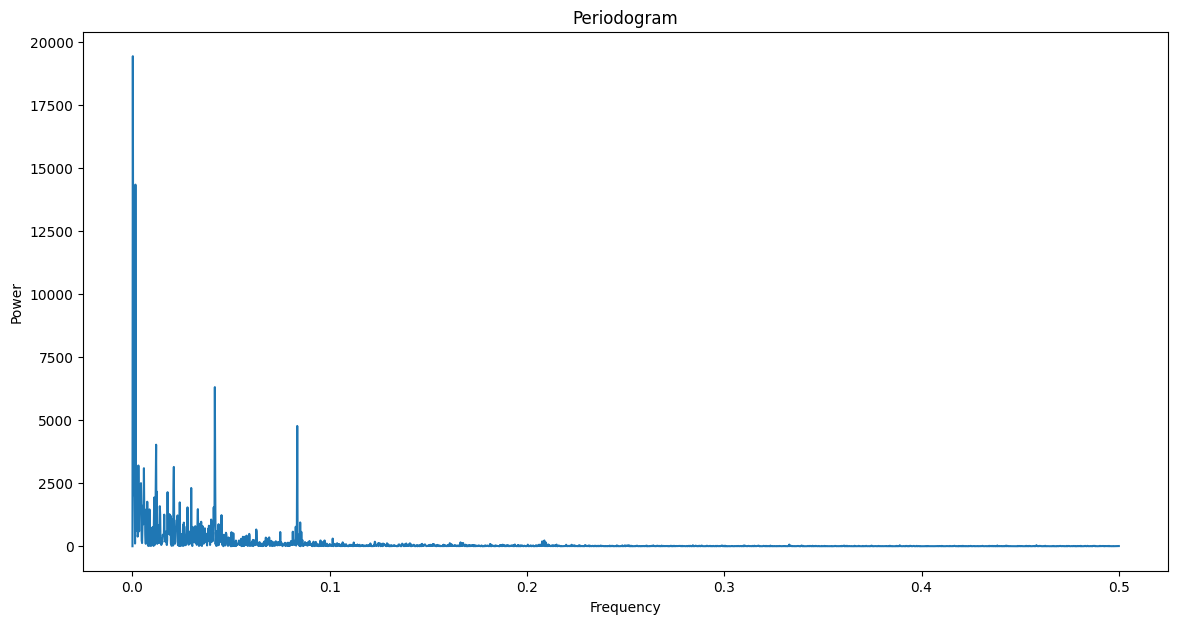

In [316]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(train['log_value'])
plt.figure(figsize=(14, 7))
plt.plot(frequencies, spectrum)
plt.title('Periodogram')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [317]:
max_idx = np.argmax(spectrum)
second_max_idx = np.argsort(spectrum)[-2]  # Get the second largest index

# Get the maximum and second maximum values
max_value = spectrum[max_idx]
second_max_value = spectrum[second_max_idx]

# Get the corresponding frequencies
max_freq = frequencies[max_idx]
second_max_freq = frequencies[second_max_idx]

In [318]:
max_freq, second_max_freq

(np.float64(0.00018726591760299626), np.float64(0.00149812734082397))

In [320]:
1/0.00149812734082397

667.5

In [321]:
seasonal_period=667

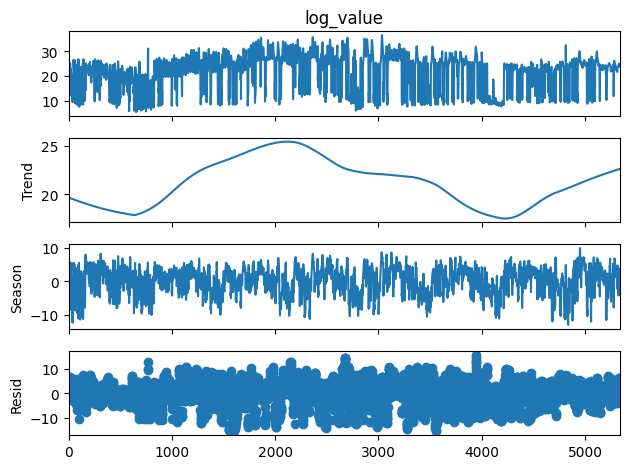

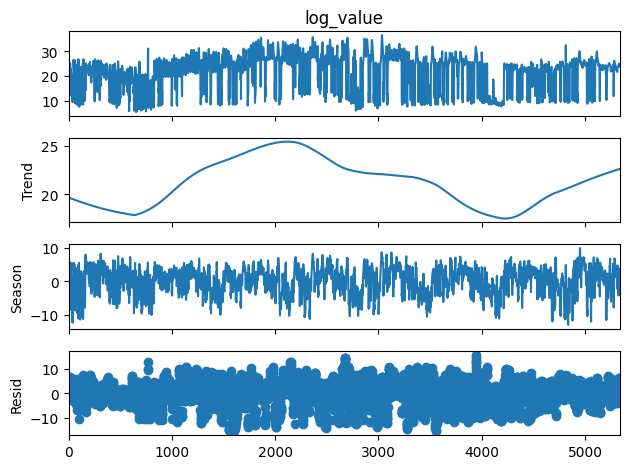

In [322]:
stl = STL(train['log_value'],period=seasonal_period)
result=stl.fit()
result.plot()

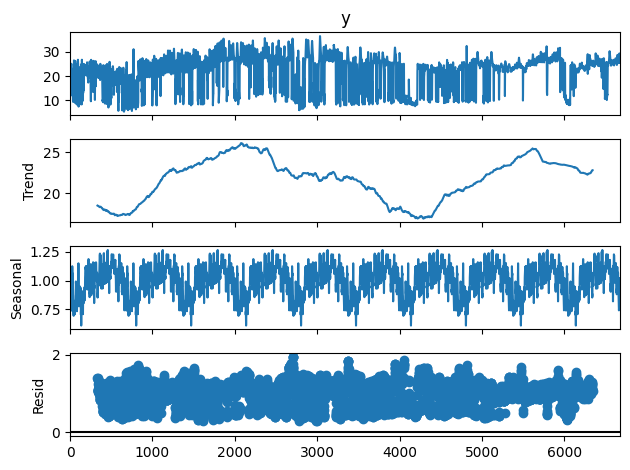

In [323]:
trend=result.trend
trend.head()
seasonal=result.seasonal

In [325]:
a=pd.DataFrame(trend)
a.shape

(5340, 1)

In [326]:
a['ds']=df1['ds']
a['unique_id']=df1['unique_id']
a['y']=a['trend']

In [327]:
a=a.dropna().reset_index(drop=True)
a.head()

,trend,ds,unique_id,y
0,3.484803e+08,2022-01-04 00:00:00,h1,3.484803e+08
1,3.470807e+08,2022-01-04 01:00:00,h1,3.470807e+08
2,3.456876e+08,2022-01-04 02:00:00,h1,3.456876e+08
3,3.443010e+08,2022-01-04 03:00:00,h1,3.443010e+08
4,3.429207e+08,2022-01-04 04:00:00,h1,3.429207e+08


In [328]:
a.shape

(5340, 4)

In [288]:
model=XGBRegressor(random_state=990,learning_rate=0.01,n_estimators=500,max_depth=10,reg_lambda=0.2)
ftsc=MLForecast(
    models={
        'xgb':model,
        # 'prophet':ProphetWrapper(),
    },
    freq='H',
    lags=[168,30],
    lag_transforms={
        30:[(rolling_mean,30),(rolling_std,30),(rolling_min,30),(rolling_max,30)],
        168:[(rolling_mean,168),(rolling_std,168),(rolling_min,168),(rolling_max,168)],
    #     350:[(rolling_mean,350),(rolling_std,350),(rolling_min,350),(rolling_max,350)],
    #     720:[(rolling_mean,720),(rolling_std,720),(rolling_min,720),(rolling_max,720)]
    },
    target_transforms=[Differences([350])],
    date_features=['hour','day','weekday','month','year'],
)
ftsc.fit(a,id_col='unique_id',time_col='ds',target_col='y')
# min_child_weight=
# ,gamma=
# ,subsample=
# objective="reg:squarederror",

MLForecast(models=[xgb], freq=H, lag_features=['lag168', 'lag30', 'rolling_mean_lag30_window_size30', 'rolling_std_lag30_window_size30', 'rolling_min_lag30_window_size30', 'rolling_max_lag30_window_size30', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168', 'rolling_min_lag168_window_size168', 'rolling_max_lag168_window_size168'], date_features=['hour', 'day', 'weekday', 'month', 'year'], num_threads=1)

In [289]:
preds=ftsc.predict(1336)
preds.head()

,unique_id,ds,xgb
0,h1,2022-08-14 12:00:00,3.074357
1,h1,2022-08-14 13:00:00,3.074578
2,h1,2022-08-14 14:00:00,3.074799
3,h1,2022-08-14 15:00:00,3.075101
4,h1,2022-08-14 16:00:00,3.075122


In [290]:
seasonal.shape
# 24*7*12

(5340,)

In [291]:
z=len(preds['xgb'])
z

1336

In [292]:
# Align the seasonality with the predicted trend
# For simplicity, let's assume the seasonality pattern is repetitive and we extend it to match the trend length

# Repeat the seasonality to match the length of the predicted trend
extended_seasonal = np.tile(seasonal[-seasonal_period:], int(np.ceil( 1336 / seasonal_period)))[:1336]
extended_seasonal = pd.Series(extended_seasonal, index=test.index)


In [293]:
seasonal=pd.DataFrame(seasonal)
extended_seasonal=pd.DataFrame(extended_seasonal)

In [294]:
seasonal['ds']=pd.to_datetime(train['ds'])
seasonal['y']=seasonal['season']
seasonal['unique_id']='h1'

In [295]:
extended_seasonal['ds']=pd.to_datetime(test['ds'])
extended_seasonal['z']=extended_seasonal[0]
extended_seasonal['unique_id']='h1'

In [296]:
seasonal.tail()

,season,ds,y,unique_id
5335,0.217934,2022-08-14 07:00:00,0.217934,h1
5336,0.211611,2022-08-14 08:00:00,0.211611,h1
5337,0.203163,2022-08-14 09:00:00,0.203163,h1
5338,0.242905,2022-08-14 10:00:00,0.242905,h1
5339,0.243056,2022-08-14 11:00:00,0.243056,h1


In [297]:
extended_seasonal.head()

,0,ds,z,unique_id
5340,0.162967,2022-08-14 12:00:00,0.162967,h1
5341,-0.062377,2022-08-14 13:00:00,-0.062377,h1
5342,-0.121801,2022-08-14 14:00:00,-0.121801,h1
5343,-0.069765,2022-08-14 15:00:00,-0.069765,h1
5344,-0.056822,2022-08-14 16:00:00,-0.056822,h1


In [330]:
extended_seasonal.drop(columns=[0],inplace=True)

In [331]:
train.head()

,unique_id,ds,y,log_value
0,h1,2022-01-04 00:00:00,20.867,20.867
1,h1,2022-01-04 01:00:00,21.000,21.000
2,h1,2022-01-04 02:00:00,20.867,20.867
3,h1,2022-01-04 03:00:00,20.650,20.650
4,h1,2022-01-04 04:00:00,20.400,20.400


In [332]:
preds.head()

,unique_id,ds,xgb
0,h1,2022-08-14 12:00:00,3.237323
1,h1,2022-08-14 13:00:00,3.012201
2,h1,2022-08-14 14:00:00,2.952998
3,h1,2022-08-14 15:00:00,3.005336
4,h1,2022-08-14 16:00:00,3.018300


In [333]:
plot_series(seasonal,extended_seasonal)

ValueError: `df` must be either pandas or polars dataframe, got <class 'pandas.core.series.Series'>

In [302]:
preds['xgb']

0       3.074357
1       3.074578
2       3.074799
3       3.075101
4       3.075122
          ...   
1331    3.330950
1332    3.330651
1333    3.330828
1334    3.331004
1335    3.331180
Name: xgb, Length: 1336, dtype: float64

In [303]:
q=extended_seasonal['z'].reset_index()

In [304]:
q

,index,z
0,5340,0.162967
1,5341,-0.062377
2,5342,-0.121801
3,5343,-0.069765
4,5344,-0.056822
...,...,...
1331,6671,0.203163
1332,6672,0.242905
1333,6673,0.243056
1334,6674,0.162967


In [305]:
preds['xgb']=preds['xgb']+q['z']

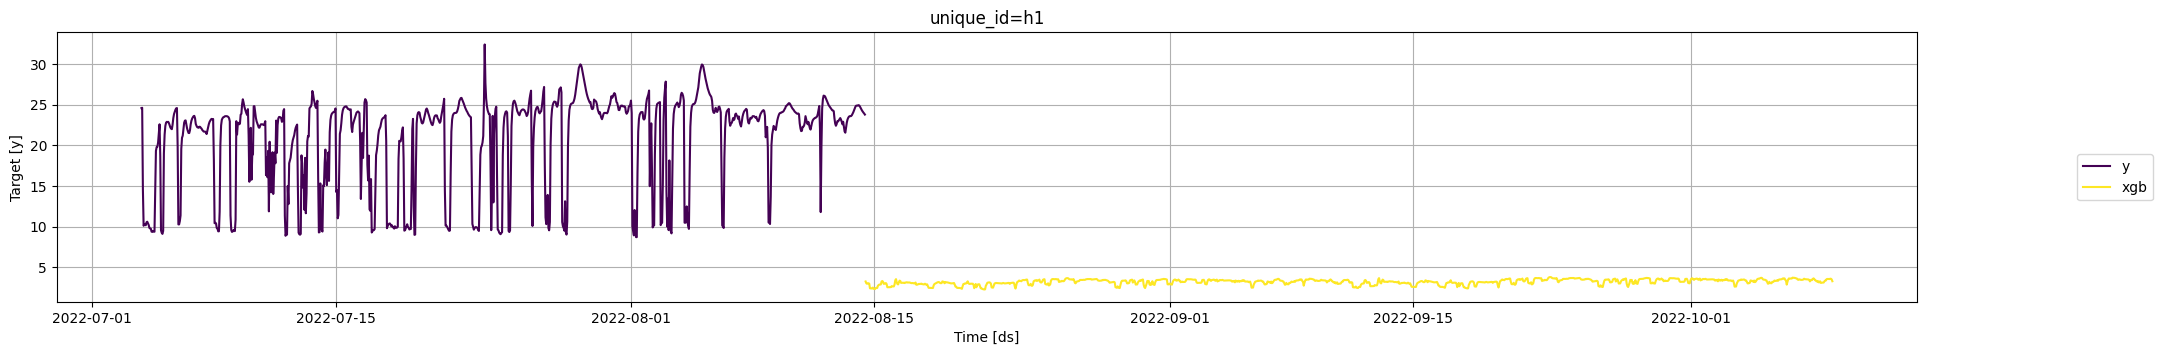

In [306]:
plot_series(train,preds,max_insample_length=1000)

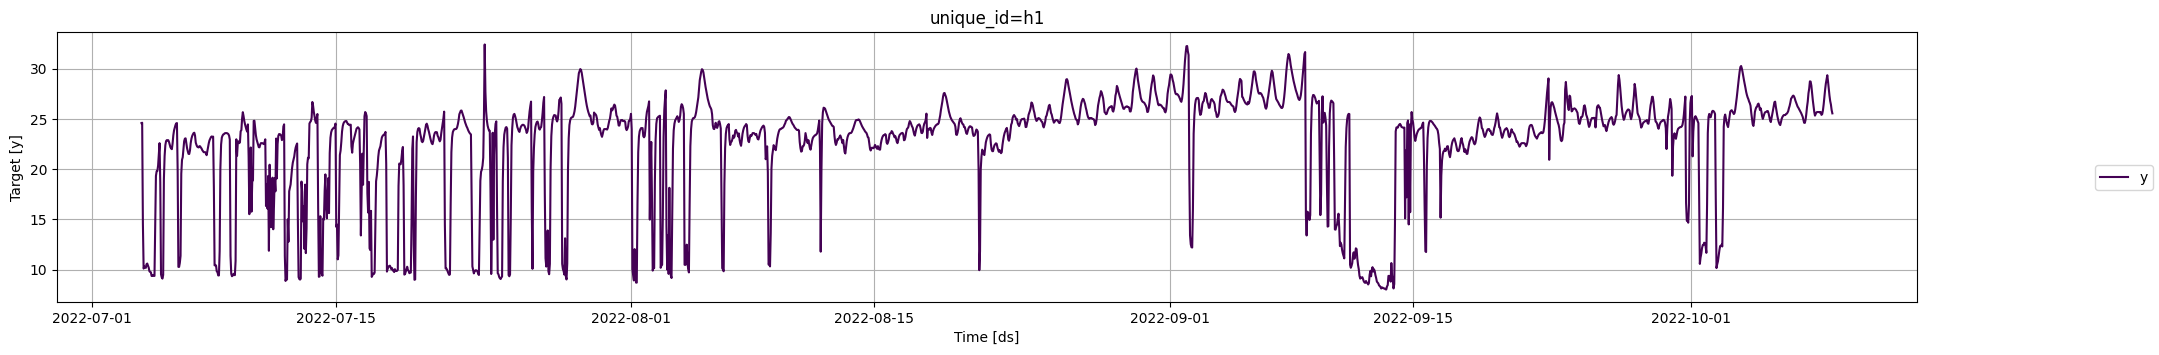

In [307]:
plot_series(train,test,max_insample_length=1000)

In [308]:
preds['xgb']
extended_seasonal['z']

5340    0.162967
5341   -0.062377
5342   -0.121801
5343   -0.069765
5344   -0.056822
          ...   
6671    0.203163
6672    0.242905
6673    0.243056
6674    0.162967
6675   -0.062377
Name: z, Length: 1336, dtype: float64

In [309]:
mse_test = mean_squared_error(test['y'], preds['xgb'])
mse_test

np.float64(452.67678261706845)